In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import os
import glob
import datetime as dt
from salishsea_tools import viz_tools
from matplotlib.ticker import FormatStrFormatter
import cmocean
from salishsea_tools import viz_tools, evaltools as et
from salishsea_tools import visualisations
import NorthNut as nn
import matplotlib.gridspec as gridspec
import pickle
import matplotlib as mpl
import matplotlib.patheffects as path_effects
import matplotlib.colors as colors
from matplotlib.mlab import bivariate_normal
import matplotlib.gridspec as gridspec
fs=8 # fs=8
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble = ','.join(r'''
 \usepackage{txfonts}
 \usepackage{lmodern}
 '''.split()))
mpl.rc('font', family='sans-serif', weight='normal', style='normal')
%matplotlib inline

NorthNut defined variables: ig0,ig1,jg0,jg1,fformat0
NorthNut defined variables: vmask, vmask0, umask, umask0, tmask, fmask, gdept,  gdept_1d, e1t, e2t, e12t, e1f, e2f, e1v, e2u, e3t_1d
NorthNut defined variables: boxCol, colL, colR, arrowwidth, headwidth, headlength, alen, toff, apw, apk


In [2]:
### redo vertical indexing: want 6th T cell (5.5m) and the w level under it (6m):
kT=5
kW=6

In [3]:
start=dt.datetime(2015,5,11) # make sure start and end are consistent between hindcast and GLS files
end=dt.datetime(2015,5,30) # end quickly for now- calculations too long
mod_basedir='/data/eolson/results/MEOPAR/SS36runs/linkHC201812/'
mod_basedir_GLS='/data/eolson/results/MEOPAR/SS36runs/CedarRuns/GLS_Summer15/'
mod_nam_fmt='nowcast'
mod_nam_fmt_GLS='long'
mod_flen=1
mod_flen_GLS=10
saveloc='/data/eolson/results/MEOPAR/SS36runs/calcFiles/NTransport/'
fver='HC201812'

In [4]:
ig0=nn.ig0
ig1=nn.ig1
jg0=nn.jg0
jg1=nn.jg1
tmaskDIAN=nn.tmask
umaskDIAN=nn.umask
vmaskDIAN=nn.vmask

In [5]:
iso90_pts=np.loadtxt('/ocean/eolson/MEOPAR/analysis-elise/notebooks/NorthernNitrate/ts90.txt', delimiter=' ', dtype=int)
iso90=np.array([[a,b] for (a,b) in iso90_pts if ((a-644)<130)])
iso90_DIAN=np.array([[a-644,b-112] for (a,b) in iso90])

In [6]:
mesh=nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc')
#bathyf=nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
depthT = mesh.variables['gdept_0'][0, ...]
depthU = mesh.variables['gdepu'][0, ...]
depthV = mesh.variables['gdepv'][0, ...]
depthW = mesh.variables['gdepw_0'][0, ...]
e1t=mesh.variables['e1t'][0,...]
e2t=mesh.variables['e2t'][0,...]
mbathyT=mesh.variables['mbathy'][0,...]
mbathyU=np.sum(mesh.variables['umask'][0,:,:,:],0)
mbathyV=np.sum(mesh.variables['vmask'][0,:,:,:],0)
tmask=mesh.variables['tmask'][0,:,:,:]
umask=mesh.variables['umask'][0,:,:,:]
vmask=mesh.variables['vmask'][0,:,:,:]
fmask=mesh.variables['fmask'][0,:,:,:]
e1f=np.copy(mesh.variables['e1f'][0,jg0:jg1,ig0:ig1])
e2f=np.copy(mesh.variables['e2f'][0,jg0:jg1,ig0:ig1])
e3t_0=np.copy(mesh.variables['e3t_0'][0,:,:,:])
e3w_0=np.copy(mesh.variables['e3w_0'][0,:,:,:])
tmaska=mesh.variables['tmask'][:,:,jg0:jg1,ig0:ig1]
tmask90=tmaska[:,:,iso90_DIAN[:,0],iso90_DIAN[:,1]]
e3t90=e3t_0[:,iso90_DIAN[:,0],iso90_DIAN[:,1]]
e3w90=e3w_0[:,iso90_DIAN[:,0],iso90_DIAN[:,1]]

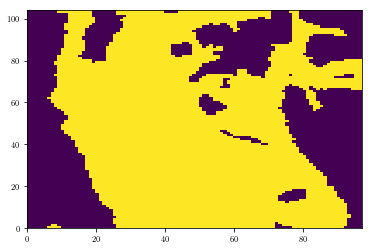

In [7]:
fig,ax=plt.subplots(1,1)
ax.pcolormesh(tmaska[0,0,iso90_DIAN[0,0]:iso90_DIAN[-1,0],:])

In [8]:
np.shape(tmask90)

(1, 40, 105)

In [9]:
kT

5

In [10]:
print(mesh.variables['gdept_1d'][:])
print(mesh.variables['gdepw_1d'][:])
print(mesh.variables['gdept_1d'][0,kT],mesh.variables['gdepw_1d'][0,kW])

[[  0.50000027   1.50000314   2.5000115    3.50003055   4.50007042
    5.50015083   6.50031022   7.50062342   8.50123623   9.50243254
   10.5047653   11.50931127  12.51816684  13.53541212  14.56898216
   15.63428737  16.76117342  18.00713456  19.48178514  21.38997868
   24.10025665  28.22991514  34.68575798  44.51772486  58.48433368
   76.58558445  98.06295924 121.8665184  147.08945807 173.11448217
  199.57304923 226.26030574 253.06663733 279.93454976 306.83419736
  333.75016973 360.6745318  387.60320347 414.53408835 441.46610968]]
[[  0.           1.00000123   2.00000639   3.00001921   4.00004695
    5.00010374   6.00021712   7.00044072   8.00087898   9.00173537
   10.00340608  11.00666275  12.01300785  13.02536622  14.04942854
   15.09625559  16.18730348  17.36403385  18.7059723   20.36347338
   22.61306387  25.93741305  31.10103509  39.1188566   50.96323669
   67.05207424  86.96747037 109.73706598 134.34593444 160.02956159
  186.30527815 212.89655735 239.65304462 266.49521437 293.38

In [11]:
Az=e1t*e2t

In [12]:
bathyT=np.sum(np.ma.masked_where(mesh.variables['tmask'][0,:,:,:]==0,mesh.variables['e3t_0'][0,:,:,:]),0)
bathyU=np.sum(np.ma.masked_where(mesh.variables['umask'][0,:,:,:]==0,mesh.variables['e3u_0'][0,:,:,:]),0)
bathyV=np.sum(np.ma.masked_where(mesh.variables['vmask'][0,:,:,:]==0,mesh.variables['e3v_0'][0,:,:,:]),0)

In [13]:
iso90_pts=np.loadtxt('/ocean/eolson/MEOPAR/analysis-elise/notebooks/NorthernNitrate/ts90.txt', delimiter=' ', dtype=int)
iso90=np.array([[a,b] for (a,b) in iso90_pts if ((a-644)<130)])
iso90_DIAN=np.array([[a-644,b-112] for (a,b) in iso90])

In [14]:
dep_thalV, distanceV, thVmask = visualisations.load_thalweg(
            depthV, mesh.variables['vmask'][0,:,:,:], mesh.variables['nav_lon'][:], mesh.variables['nav_lat'][:],
            iso90)
dep_thalV90, distanceV90, thlatV90 = visualisations.load_thalweg(
            depthV, mesh.variables['nav_lat'][:,:]*np.ones(np.shape(mesh.variables['vmask'][0,:,:,:])), mesh.variables['nav_lon'][:], mesh.variables['nav_lat'][:],
            iso90)

In [15]:
mesh.close()

In [16]:
# load new GLS output, except for e3t and ssh
fliste3t=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'carp_T',1)
flistT=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'grid_T',1)
flistU=et.index_model_files(start,end,mod_basedir_GLS,mod_nam_fmt_GLS,mod_flen_GLS,'dian_U',1)
flistV=et.index_model_files(start,end,mod_basedir_GLS,mod_nam_fmt_GLS,mod_flen_GLS,'dian_V',1)
flistW=et.index_model_files(start,end,mod_basedir_GLS,mod_nam_fmt_GLS,mod_flen_GLS,'dian_W',1)
flistB=et.index_model_files(start,end,mod_basedir_GLS,mod_nam_fmt_GLS,mod_flen_GLS,'nbio_T',1)
flistR=et.index_model_files(start,end,mod_basedir_GLS,mod_nam_fmt_GLS,mod_flen_GLS,'npro_T',1)
flistP=et.index_model_files(start,end,mod_basedir_GLS,mod_nam_fmt_GLS,mod_flen_GLS,'nphy_T',1)

ftype=dian_U, are you sure? (if yes, add to list)
ftype=dian_V, are you sure? (if yes, add to list)
ftype=dian_W, are you sure? (if yes, add to list)
ftype=nbio_T, are you sure? (if yes, add to list)
ftype=npro_T, are you sure? (if yes, add to list)
ftype=nphy_T, are you sure? (if yes, add to list)


In [17]:
iso90_DIAN[-1,:]

array([115,  13])

In [18]:
sti=list()
sti1=list()
sti2=list()
e3t_i=list()
tc_i=list()
for iif in range(0,len(flistT)):
    print('iif=',iif)
    with nc.Dataset(fliste3t.loc[iif,['paths']].values[0]) as fe3t,\
              nc.Dataset(flistT.loc[iif,['paths']].values[0]) as fT:
        # extract fields to numpy variables for faster transect extraction:
        sshe=np.copy(fT.variables['sossheig'][:,jg0:jg1,ig0:ig1])
        e3te=np.copy(fe3t.variables['e3t'][:,:,jg0:jg1,ig0:ig1])*tmask[:,jg0:jg1,ig0:ig1]
        tc_i.append(fT.variables['time_centered'][:])
    # 1st extract Discovery mouth transect for diagnosing tidal phase:
    sti.append(np.sum(tmaskDIAN[0,93,9:16]*sshe[:,93,9:16],1)/np.sum(tmaskDIAN[0,93,9:16]))
    sti1.append(sshe[:,iso90_DIAN[-1,0],iso90_DIAN[-1,1]])
    sti2.append(sshe[:,iso90_DIAN[0,0],iso90_DIAN[0,1]])
    e3t_i.append(e3te[:,:, iso90_DIAN[:, 0], iso90_DIAN[:, 1]])

st=np.concatenate(sti,axis=0)
st1=np.concatenate(sti1,axis=0)
st2=np.concatenate(sti2,axis=0)
e3t=np.concatenate(e3t_i,axis=0)
tc=np.concatenate(tc_i,axis=0)


del sti, sti1, sti2, e3t_i, tc_i

iif= 0
iif= 1
iif= 2
iif= 3
iif= 4
iif= 5
iif= 6
iif= 7
iif= 8
iif= 9
iif= 10
iif= 11
iif= 12
iif= 13
iif= 14
iif= 15
iif= 16
iif= 17
iif= 18
iif= 19


In [19]:
e3w=e3t/e3t90*e3w90

In [20]:
np.shape(e3t)

(480, 40, 105)

In [21]:
iso90_DIAN[-1,:]

array([115,  13])

In [22]:
test=np.zeros((24,40,105))
for jj in range(0,len(iso90_DIAN[:, 0])):
    test[:,:,jj]=np.sum(e3te[:,:,iso90_DIAN[jj,0],:iso90_DIAN[jj,1]]*tmaskDIAN[:,iso90_DIAN[jj,0],:iso90_DIAN[jj,1]],2)/np.sum(tmaskDIAN[:,iso90_DIAN[jj,0],:iso90_DIAN[jj,1]],1)

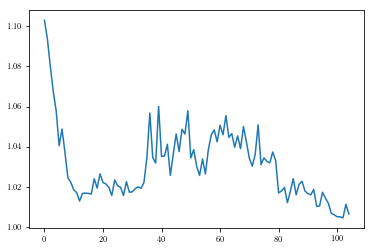

In [23]:
plt.plot(test[0,0,:])

In [24]:
GLS_P_i=list()
GLS_G_i=list()
bfN2_i=list()
GLS_k_i=list()
GLS_eps_i=list()
no3_i=list()
Wno3_i=list()
vvel_i=list()
vvel_a6_i=list()
GLS_k_a6_i=list()
wvel_i=list()
VMIXNO3_i=list()
WVMIXNO3_i=list()
WTNO3_i=list()
TNO3_i=list()
PPTot_i=list()
rho_i=list()

flistV=et.index_model_files(start,end,mod_basedir_GLS,mod_nam_fmt_GLS,mod_flen_GLS,'dian_V',1)
flistW=et.index_model_files(start,end,mod_basedir_GLS,mod_nam_fmt_GLS,mod_flen_GLS,'dian_W',1)
flistB=et.index_model_files(start,end,mod_basedir_GLS,mod_nam_fmt_GLS,mod_flen_GLS,'nbio_T',1)
for iif in range(0,len(flistV)):
    print('iif=',iif)
    with nc.Dataset(flistV.loc[iif,['paths']].values[0]) as fV,\
          nc.Dataset(flistW.loc[iif,['paths']].values[0]) as fW,\
           nc.Dataset(flistB.loc[iif,['paths']].values[0]) as fB,\
            nc.Dataset(flistP.loc[iif,['paths']].values[0]) as fP,\
             nc.Dataset(flistR.loc[iif,['paths']].values[0]) as fR:
        # extract fields to numpy variables for faster transect extraction:'GLS_G', 'GLS_P', 'eps', 'bfN2',rhop
        GLS_Pe=np.copy(fW.variables['GLS_P'][:,:,:,:])
        GLS_Ge=np.copy(fW.variables['GLS_G'][:,:,:,:])
        GLS_ke=np.copy(fW.variables['GLS_k'][:,:,:,:])
        GLS_ee=np.copy(fW.variables['GLS_eps'][:,:,:,:])
        bfN2e=np.copy(fW.variables['bfN2'][:,:,:,:])
        no3e=np.copy(fB.variables['nitrate'][:,:,:,:])
        vvele=np.copy(fV.variables['vomecrty'][:,:,:,:])
        wvele=np.copy(fW.variables['vovecrtz'][:,:,:,:])
        wvele=np.copy(fW.variables['vovecrtz'][:,:,:,:])
        
        vmixno3e=np.copy(fW['VMIXNO3'][:,:,:,:]) # this is a DIAN file
        wtno3e=np.copy(fW['NO3_WT'][:,:,:,:]) # this is a DIAN file
        PPDiate=np.copy(fR['PPDIATNO3'][:,:,:,:])
        PPMrube=np.copy(fR['PPMRUBNO3'][:,:,:,:])
        PPPhye=np.copy(fR['PPPHYNO3'][:,:,:,:])
        rhoe=np.copy(fP['rhop'][:,:,:,:])
    no3_i.append(no3e[:,:, iso90_DIAN[:, 0], iso90_DIAN[:, 1]])
    temp=np.zeros(np.shape(no3e[:,:, iso90_DIAN[:, 0], iso90_DIAN[:, 1]]))
    for jj in range(0,len(iso90_DIAN[:, 0])):
        temp[:,:,jj]=np.sum(no3e[:,:,iso90_DIAN[jj,0],:iso90_DIAN[jj,1]]*tmaskDIAN[:,iso90_DIAN[jj,0],:iso90_DIAN[jj,1]],2)/\
            np.sum(tmaskDIAN[:,iso90_DIAN[jj,0],:iso90_DIAN[jj,1]],1)
    Wno3_i.append(temp)
    temp=np.zeros(np.shape(no3e[:,:, iso90_DIAN[:, 0], iso90_DIAN[:, 1]]))
    for jj in range(0,len(iso90_DIAN[:, 0])):
        temp[:,:,jj]=np.sum(vmixno3e[:,:,iso90_DIAN[jj,0],:iso90_DIAN[jj,1]]*tmaskDIAN[:,iso90_DIAN[jj,0],:iso90_DIAN[jj,1]]\
                            *e1t[iso90[jj,0],ig0:iso90[jj,1]],2) # mmol/m/s
    WVMIXNO3_i.append(temp)
    temp=np.zeros(np.shape(no3e[:,:, iso90_DIAN[:, 0], iso90_DIAN[:, 1]]))
    for jj in range(0,len(iso90_DIAN[:, 0])):
        temp[:,:,jj]=np.sum(wtno3e[:,:,iso90_DIAN[jj,0],:iso90_DIAN[jj,1]]*tmaskDIAN[:,iso90_DIAN[jj,0],:iso90_DIAN[jj,1]]\
                            /e2t[iso90[jj,0],ig0:iso90[jj,1]],2) # mmol/m/s
    WTNO3_i.append(temp)
    TNO3_i.append(wtno3e[:,:, iso90_DIAN[:, 0], iso90_DIAN[:, 1]])
    rho_i.append(rhoe[:,:, iso90_DIAN[:, 0], iso90_DIAN[:, 1]])
    vvel_i.append(vvele[:,:, iso90_DIAN[:, 0], iso90_DIAN[:, 1]])
    vvel_a6_i.append(vvele[:,7, :, :])
    wvel_i.append(wvele[:,:, iso90_DIAN[:, 0], iso90_DIAN[:, 1]])
    GLS_P_i.append(GLS_Pe[:,:, iso90_DIAN[:, 0], iso90_DIAN[:, 1]])
    GLS_G_i.append(GLS_Ge[:,:, iso90_DIAN[:, 0], iso90_DIAN[:, 1]])
    GLS_eps_i.append(GLS_ee[:,:, iso90_DIAN[:, 0], iso90_DIAN[:, 1]])
    bfN2_i.append(bfN2e[:,:, iso90_DIAN[:, 0], iso90_DIAN[:, 1]])
    GLS_k_i.append(GLS_ke[:,:, iso90_DIAN[:, 0], iso90_DIAN[:, 1]])
    GLS_k_a6_i.append(GLS_ke[:,7, :, :])
    VMIXNO3_i.append(vmixno3e[:,:,iso90_DIAN[:, 0], iso90_DIAN[:, 1]])
    PPTot_i.append(PPDiate[:,:,iso90_DIAN[:, 0], iso90_DIAN[:, 1]]+\
                   PPMrube[:,:,iso90_DIAN[:, 0], iso90_DIAN[:, 1]]+\
                   PPPhye[:,:,iso90_DIAN[:, 0], iso90_DIAN[:, 1]])
GLS_P=np.concatenate(GLS_P_i,axis=0)
GLS_G=np.concatenate(GLS_G_i,axis=0)
GLS_eps=np.concatenate(GLS_eps_i,axis=0)
bfN2=np.concatenate(bfN2_i,axis=0)
GLS_k=np.concatenate(GLS_k_i,axis=0)
no3=np.concatenate(no3_i,axis=0)
Wno3=np.concatenate(Wno3_i,axis=0)
vvel=np.concatenate(vvel_i,axis=0)
wvel=np.concatenate(wvel_i,axis=0)
VMIXNO3=np.concatenate(VMIXNO3_i,axis=0)
WVMIXNO3=np.concatenate(WVMIXNO3_i,axis=0)
vvel_a6=np.concatenate(vvel_a6_i,axis=0)
GLS_k_a6=np.concatenate(GLS_k_a6_i,axis=0)
PPTot=np.concatenate(PPTot_i,axis=0)
rho=np.concatenate(rho_i,axis=0)
WTNO3=np.concatenate(WTNO3_i,axis=0)
TNO3=np.concatenate(TNO3_i,axis=0)
del GLS_P_i, GLS_k_i

ftype=dian_V, are you sure? (if yes, add to list)
ftype=dian_W, are you sure? (if yes, add to list)
ftype=nbio_T, are you sure? (if yes, add to list)
iif= 0
iif= 1


In [25]:

swid=np.zeros(len(iso90_DIAN[:, 1]))
for jj in range(0,len(iso90_DIAN[:, 0])):
    swid[jj]=np.sum(tmaskDIAN[0,iso90_DIAN[jj,0],:iso90_DIAN[jj,1]])

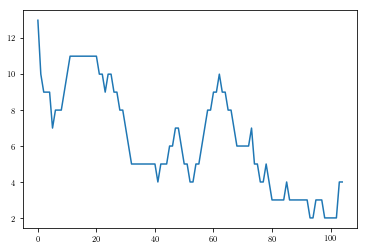

In [26]:
plt.plot(swid)

In [27]:
np.shape(tmask[:,iso90[:, 0], iso90[:, 1]])

(40, 105)

In [28]:
np.shape(e3t*tmask[:,iso90[:, 0], iso90[:, 1]]),np.shape(vvel),np.shape(st1)

((480, 40, 105), (480, 40, 105), (480,))

In [29]:
h=np.fliplr(np.cumsum(np.fliplr(e3t),1))
dhdt=(h[2:,:,:]-h[:-2,:,:])/(2*24*3600)

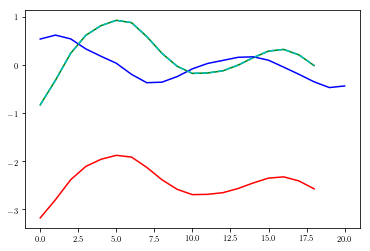

In [30]:
fig,ax=plt.subplots(1,1)
ax.plot(h[1:20,0,-1]-86.85,'g-')
ax.plot(h[1:20,20,-1]-66.85,'r-')
ax.plot(100000*dhdt[:21,0,-1],'b-')
ax.plot(st1[1:20],'c--')

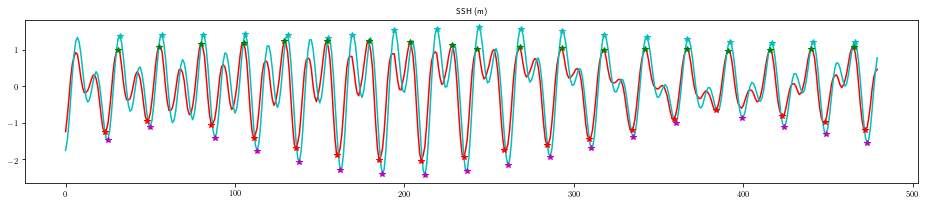

In [31]:
fig,ax=plt.subplots(1,1,figsize=(16,3))
ax.plot(st1,'r-')
ax.plot(st2,'c-')
ax.set_title('SSH (m)')
imin=list()
imax=list()
ilo=list()
ihi=list()
for ii in range(1,int(np.floor(len(st1)/24))):
    hsub=st1[(ii*24):(ii*24+25)]
    ihi0=np.argmax(hsub)+ii*24
    ilo0=np.argmin(hsub)+ii*24
    ihi.append(np.argmax(st1[(ihi0-2):(ihi0+3)])+ihi0-2)
    ilo.append(np.argmin(st1[(ilo0-2):(ilo0+3)])+ilo0-2)
ihi1=np.unique(ihi)
ilo1=np.unique(ilo)
imin=list()
imax=list()
ilo=list()
ihi=list()
for ii in range(1,int(np.floor(len(st2)/24))):
    hsub=st[(ii*24):(ii*24+25)]
    ihi0=np.argmax(hsub)+ii*24
    ilo0=np.argmin(hsub)+ii*24
    ihi.append(np.argmax(st2[(ihi0-2):(ihi0+3)])+ihi0-2)
    ilo.append(np.argmin(st2[(ilo0-2):(ilo0+3)])+ilo0-2)
ihi2=np.unique(ihi)
ilo2=np.unique(ilo)
ax.plot(ilo2,st2[ilo2],'m*')
ax.plot(ihi2,st2[ihi2],'c*')
ax.plot(ilo1,st1[ilo1],'r*')
ax.plot(ihi1,st1[ihi1],'g*')

In [32]:
ihi2-ihi1

array([  1,   2,   1,   1,   2,   1, -10,  -9,  -9,   1,   1,   0,   0,
         1,   0,   1,   1,   1,   1])

In [33]:
ilo2-ilo1

array([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  1,  1, 15,  1,  1,
        1])

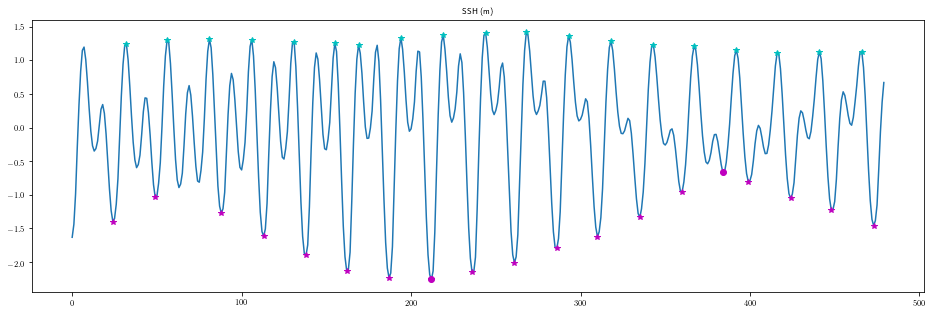

In [34]:
fig,ax=plt.subplots(1,1,figsize=(16,5))
ax.plot(st)
ax.set_title('SSH (m)')
imin=list()
imax=list()
ilo=list()
ihi=list()
for ii in range(1,int(np.floor(len(st)/24))):
    hsub=st[(ii*24):(ii*24+25)]
    ihi0=np.argmax(hsub)+ii*24
    ilo0=np.argmin(hsub)+ii*24
    ihi.append(np.argmax(st[(ihi0-2):(ihi0+3)])+ihi0-2)
    ilo.append(np.argmin(st[(ilo0-2):(ilo0+3)])+ilo0-2)
ihi=np.unique(ihi)
ilo=np.unique(ilo)
ax.plot(ilo,st[ilo],'m*')
ax.plot(ihi,st[ihi],'c*')
ax.plot(ilo[7],st[ilo[7]],'mo')
ax.plot(ilo[14]-15,st[ilo[14]-15],'mo')

In [35]:
cmb=cmocean.cm.balance
cma=cmocean.cm.amp
cmp=cmocean.cm.tempo
cmp.set_bad('white')
cmb.set_bad('white')
cma.set_bad('white')

In [36]:
extend='neither'
pcol='grey'
amp=.5
tt0=ilo[7]
tt1=ilo[14]-15

In [37]:
w6=dhdt[tt0-1:tt0+49,kW,:]
w6_1=dhdt[tt1-1:tt1+49,kW,:]

In [38]:
np.shape(tmask90)

(1, 40, 105)

In [39]:
hv6=vvel[tt0:tt0+50,kT,:]
rho090=rho[tt0:tt0+50,0,:]
GLS_P90=GLS_P[tt0:tt0+50,kW,:]
GLS_G90=GLS_G[tt0:tt0+50,kW,:]
bfN290=bfN2[tt0:tt0+50,kW,:]
GLS_k90=GLS_k[tt0:tt0+50,kW,:]
GLS_eps90=GLS_eps[tt0:tt0+50,kW,:]
wvel90=wvel[tt0:tt0+50,kW,:]
VMIXNO390=VMIXNO3[tt0:tt0+50,kW,:]
WVMIXNO390=WVMIXNO3[tt0:tt0+50,kW,:]
NO390=no3[tt0:tt0+50,kT,:]
mNO390=np.sum(no3[tt0:tt0+50,:kW,:]*e3t[tt0:tt0+50,:kW,:],1)/np.sum(e3t[tt0:tt0+50,:kW,:],1)
SNO390=no3[tt0:tt0+50,0,:]
WNO390=Wno3[tt0:tt0+50,0,:]
WTNO390=WTNO3[tt0:tt0+50,kW,:]
TNO390=TNO3[tt0:tt0+50,kW,:]
PP90=PPTot[tt0:tt0+50,kT,:]
IPP90=np.sum(PPTot[tt0:tt0+50,:,:]*e3t[tt0:tt0+50,:,:]*tmask90,1)
tcs=tc[tt0:tt0+50]
#hh=np.sum(tmask[:,])
hv6_1=vvel[tt1:(tt1+50),kT,:]
rho0_1=rho[tt1:(tt1+50),0,:]
GLS_P90_1=GLS_P[tt1:tt1+50,kW,:]
bfN290_1=bfN2[tt1:tt1+50,kW,:]
GLS_k90_1=GLS_k[tt1:tt1+50,kW,:]
GLS_eps90_1=GLS_eps[tt1:tt1+50,kW,:]
wvel90_1=wvel[tt1:tt1+50,kW,:]
VMIXNO390_1=VMIXNO3[tt1:tt1+50,kW,:]
WVMIXNO390_1=WVMIXNO3[tt1:tt1+50,kW,:]
NO390_1=no3[tt1:tt1+50,kT,:]
mNO390_1=np.sum(no3[tt1:tt1+50,:kW,:]*e3t[tt1:tt1+50,:kW,:],1)/np.sum(e3t[tt1:tt1+50,:kW,:],1)
SNO390_1=no3[tt1:tt1+50,0,:]
WNO390_1=Wno3[tt1:tt1+50,0,:]
WTNO390_1=WTNO3[tt1:tt1+50,kW,:]
TNO390_1=TNO3[tt1:tt1+50,kW,:]
PP90_1=PPTot[tt1:tt1+50,kT,:]
IPP90_1=np.sum(PPTot[tt1:tt1+50,:,:]*e3t[tt1:tt1+50,:,:]*tmask90,1)
tcs_1=tc[tt1:tt1+50]

In [40]:
tt0,tt1,tt1+50

(212, 384, 434)

In [41]:
np.shape(hv6_1),np.shape(hv6),np.shape(vvel)

((50, 105), (50, 105), (480, 40, 105))

In [42]:
np.max(wvel90),np.max(w6),np.max(wvel90_1),np.max(w6_1)

(0.0140465945, 1.0026075221874096e-05, 0.012040576, 4.375157532868562e-06)

/home/eolson/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


(11, 115)

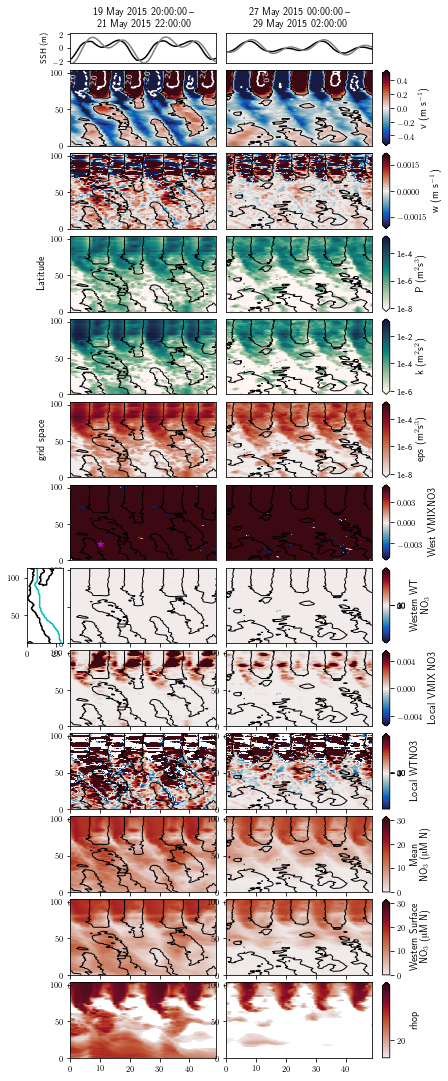

In [43]:
fig=plt.figure(figsize=(6,16))
gs0=gridspec.GridSpec(13,3,hspace=.1,wspace=.1,left=.1,right=.84,bottom=.06,top=.95,height_ratios=[.4,1,1,1,1,1,1,1,1,1,1,1,1],
                      width_ratios=[1,1,.05])

ax00=fig.add_subplot(gs0[0,0])
ax01=fig.add_subplot(gs0[0,1])
ax10=fig.add_subplot(gs0[1,0])
ax11=fig.add_subplot(gs0[1,1])
axcb1=fig.add_subplot(gs0[1,2])
ax20=fig.add_subplot(gs0[2,0])
ax21=fig.add_subplot(gs0[2,1])
axcb2=fig.add_subplot(gs0[2,2])
ax30=fig.add_subplot(gs0[3,0])
ax31=fig.add_subplot(gs0[3,1])
axcb3=fig.add_subplot(gs0[3,2])
ax40=fig.add_subplot(gs0[4,0])
ax41=fig.add_subplot(gs0[4,1])
axcb4=fig.add_subplot(gs0[4,2])
ax50=fig.add_subplot(gs0[5,0])
ax51=fig.add_subplot(gs0[5,1])
axcb5=fig.add_subplot(gs0[5,2])
ax60=fig.add_subplot(gs0[6,0])
ax61=fig.add_subplot(gs0[6,1])
axcb6=fig.add_subplot(gs0[6,2])
ax70=fig.add_subplot(gs0[7,0])
ax71=fig.add_subplot(gs0[7,1])
axcb7=fig.add_subplot(gs0[7,2])
ax80=fig.add_subplot(gs0[8,0])
ax81=fig.add_subplot(gs0[8,1])
axcb8=fig.add_subplot(gs0[8,2])
ax90=fig.add_subplot(gs0[9,0])
ax91=fig.add_subplot(gs0[9,1])
axcb9=fig.add_subplot(gs0[9,2])
ax100=fig.add_subplot(gs0[10,0])
ax101=fig.add_subplot(gs0[10,1])
axcb10=fig.add_subplot(gs0[10,2])
ax110=fig.add_subplot(gs0[11,0])
ax111=fig.add_subplot(gs0[11,1])
axcb11=fig.add_subplot(gs0[11,2])
ax120=fig.add_subplot(gs0[12,0])
ax121=fig.add_subplot(gs0[12,1])
axcb12=fig.add_subplot(gs0[12,2])
t0start=dt.datetime(1900,1,1)+dt.timedelta(seconds=tcs[0])-dt.timedelta(minutes=30)
t0end=dt.datetime(1900,1,1)+dt.timedelta(seconds=tcs[-1])+dt.timedelta(minutes=30)
t1start=dt.datetime(1900,1,1)+dt.timedelta(seconds=tcs_1[0])-dt.timedelta(minutes=30)
t1end=dt.datetime(1900,1,1)+dt.timedelta(seconds=tcs_1[-1])+dt.timedelta(minutes=30)

#ax00.plot(st[ilo[tt0]:ilo[tt0]+50])
ax00.plot(st1[tt0:tt0+50],'k-')
ax00.plot(st2[tt0:tt0+50],'-',color='grey')
ax00.set_ylabel('SSH (m)')
tfmt='%d %b %Y %H:%M:%S'
ax00.set_title('{} --\n {}'.format((t0start).strftime(tfmt),(t0end).strftime(tfmt)),fontsize=10)
ax00.set_ylim(-2.3,2.3)
#ax01.plot(st[ilo[7tt1ilo[tt1]+50])
ax01.plot(st1[tt1:tt1+50],'k-')
ax01.plot(st2[tt1:tt1+50],'-',color='grey')
ax01.set_ylabel('SSH (m)',fontsize=10)
tfmt='%d %b %Y %H:%M:%S'
ax01.set_title('{} --\n {}'.format((t1start).strftime(tfmt),(t1end).strftime(tfmt)),fontsize=10)
ax01.set_ylim(-2.3,2.3)
ax00.get_xaxis().set_visible(False)
ax10.get_xaxis().set_visible(False)
ax20.get_xaxis().set_visible(False)
ax30.get_xaxis().set_visible(False)
ax40.get_xaxis().set_visible(False)
ax50.get_xaxis().set_visible(False)
ax60.get_xaxis().set_visible(False)
ax01.get_xaxis().set_visible(False)
ax11.get_xaxis().set_visible(False)
ax21.get_xaxis().set_visible(False)
ax31.get_xaxis().set_visible(False)
ax41.get_xaxis().set_visible(False)
ax51.get_xaxis().set_visible(False)
ax61.get_xaxis().set_visible(False)
ax01.get_yaxis().set_visible(False)
ax11.get_yaxis().set_visible(False)
ax21.get_yaxis().set_visible(False)
ax31.get_yaxis().set_visible(False)
ax41.get_yaxis().set_visible(False)
ax51.get_yaxis().set_visible(False)
ax61.get_yaxis().set_visible(False)
ax71.get_yaxis().set_visible(False)

### v
amp=.5
m=ax10.contourf(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(hv6),np.linspace(-1*amp,amp,100),vmin=-1*amp,vmax=amp,
                                            cmap=cmb,extend='both')
ml0=ax10.contour(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(hv6),levels=[-2,2,],colors='w')
ax10.clabel(ml0, fmt='%2.1f', colors='w', fontsize=8)

m=ax11.contourf(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(hv6_1),np.linspace(-1*amp,amp,100),vmin=-1*amp,vmax=amp,
                                            cmap=cmb,extend='both')
ml1=ax11.contour(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(hv6_1),levels=[-2,2,],colors='w')
ax11.clabel(ml1, fmt='%2.1f', colors='w', fontsize=8)
ax11.get_yaxis().set_visible(False)
cb=fig.colorbar(m,cax=axcb1,ticks=[-.4,-.2, 0, .2,.4])
cb.set_label('v (m s$^{-1}$)',fontsize=10)

### w
amp=.002
m=ax20.contourf(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(wvel90+w6),np.linspace(-1*amp,amp,100),
                vmin=-1*amp,vmax=amp,cmap=cmb,extend='both')
#ax20.set_ylabel('Latitude')
m=ax21.contourf(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(wvel90_1+w6_1),np.linspace(-1*amp,amp,100),
                vmin=-1*amp,vmax=amp,cmap=cmb,extend='both')
cb=fig.colorbar(m,cax=axcb2,ticks=[-.0015, 0, .0015])
cb.set_label('w (m s$^{-1}$)',fontsize=10)

### GLS_P
temp=np.where(GLS_P90==0,1e-9,GLS_P90)
m=ax30.contourf(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(np.log10(temp)),np.linspace(-8,-3,101),vmin=-8,vmax=-3,
                                            cmap=cmp,extend='both')
ax30.set_ylabel('Latitude',fontsize=10)
temp=np.where(GLS_P90_1==0,1e-9,GLS_P90_1)
m=ax31.contourf(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(np.log10(temp)),np.linspace(-8,-3,101),vmin=-8,vmax=-3,
                                            cmap=cmp,extend='both')
cb=fig.colorbar(m,cax=axcb3,ticks=[-8,-6, -4])
cb.ax.set_yticklabels(['1e-8', '1e-6', '1e-4'])
cb.set_label('P (m$^2$s$^3$)',fontsize=10)

### GLS_k
temp=np.where(GLS_k90==0,1e-9,GLS_k90)
m=ax40.contourf(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(np.log10(temp)),np.linspace(-6,-1,101),vmin=-6,vmax=-1,
                                            cmap=cmp,extend='both')
#ax40.set_ylabel('Latitude')
temp=np.where(GLS_k90_1==0,1e-9,GLS_k90_1)
m=ax41.contourf(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(np.log10(temp)),np.linspace(-6,-1,101),vmin=-6,vmax=-1,
                                            cmap=cmp,extend='both')
cb=fig.colorbar(m,cax=axcb4,ticks=[-6,-4, -2])
cb.ax.set_yticklabels(['1e-6', '1e-4', '1e-2'])
cb.set_label('k (m$^2$s$^2$)',fontsize=10)

### GLS_eps
temp=np.where(GLS_eps90==0,1e-9,GLS_eps90)
m=ax50.contourf(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(np.log10(temp)),np.linspace(-8,-3,101),vmin=-8,vmax=-3,
                                            cmap=cma,extend='both')
ax50.set_ylabel('grid space',fontsize=10)
temp=np.where(GLS_P90_1==0,1e-9,GLS_P90_1)
m=ax51.contourf(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(np.log10(temp)),np.linspace(-8,-3,101),vmin=-8,vmax=-3,
                                            cmap=cma,extend='both')
cb=fig.colorbar(m,cax=axcb5,ticks=[-8,-6, -4])
cb.ax.set_yticklabels(['1e-8', '1e-6', '1e-4'])
cb.set_label('eps (m$^2$s$^3$)',fontsize=10)

#WVMIXNO3
amp=.005
m=ax60.contourf(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(WVMIXNO390),np.linspace(-1*amp,amp,100),vmin=-amp,vmax=amp,
                                            cmap=cmb,extend='both')
m=ax61.contourf(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(WVMIXNO390_1),np.linspace(-1*amp,amp,100),vmin=-amp,vmax=amp,
                                            cmap=cmb,extend='both')
cb=fig.colorbar(m,cax=axcb6,ticks=[-.003,0,.003])
cb.set_label('West VMIXNO3',fontsize=10)

### N**2
#amp=.005
#m=ax60.contourf(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(bfN290),np.linspace(-1*amp,amp,100),vmin=-amp,vmax=amp,
#                                            cmap=cmb,extend='both')
#m=ax61.contourf(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(bfN290_1),np.linspace(-1*amp,amp,100),vmin=-amp,vmax=amp,
#                                            cmap=cmb,extend='both')
#cb=fig.colorbar(m,cax=axcb6,ticks=[-.003,0,.003])
#cb.set_label('N$^2$ (s$^{-2}$)',fontsize=10)

### IPP90
#amp=.0008
#m=ax70.contourf(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(IPP90),np.linspace(0,amp,100),vmin=0,vmax=amp,
#                                            cmap=cmp,extend='max')
#m=ax71.contourf(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(IPP90_1),np.linspace(0,amp,100),vmin=0,vmax=amp,
#                                            cmap=cmp,extend='max')
#cb=fig.colorbar(m,cax=axcb7,ticks=[0,.0004,.0008])
#cb.set_label('NPP\n(mmolN m$^{-2}$s$^{-1}$)',fontsize=10)



### vmix N
amp=.005
m=ax80.contourf(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(VMIXNO390),np.linspace(-1*amp,amp,100),vmin=-1*amp,vmax=amp,
                                            cmap=cmb,extend='both')
#ax50.set_ylabel('Latitude')
m=ax81.contourf(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(VMIXNO390_1),np.linspace(-1*amp,amp,100),vmin=-1*amp,vmax=amp,
                                            cmap=cmb,extend='both')
cb=fig.colorbar(m,cax=axcb8,ticks=[-.004,0, .004])
cb.set_label('Local VMIX NO3',fontsize=10)

### TNO3
amp=2000
m=ax90.contourf(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(TNO390),np.linspace(-1*amp,amp,100),vmin=-1*amp,vmax=amp,
                                            cmap=cmb,extend='max')
m=ax91.contourf(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(TNO390_1),np.linspace(-1*amp,amp,100),vmin=-1*amp,vmax=amp,
                                            cmap=cmb,extend='max')
cb=fig.colorbar(m,cax=axcb9,ticks=[0,10, 20,30])
cb.set_label('Local WTNO3',fontsize=10)

#### N
#amp=30
#m=ax90.contourf(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(NO390),np.linspace(0,amp,100),vmin=0,vmax=amp,
#                                            cmap=cma,extend='max')
#m=ax91.contourf(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(NO390_1),np.linspace(0,amp,100),vmin=0,vmax=amp,
#                                            cmap=cma,extend='max')
#cb=fig.colorbar(m,cax=axcb9,ticks=[0,10, 20,30])
#cb.set_label('NO$_3$ ($\muup$M N)',fontsize=10)

### N
amp=30
m=ax100.contourf(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(mNO390),np.linspace(0,amp,100),vmin=0,vmax=amp,
                                            cmap=cma,extend='max')
m=ax101.contourf(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(mNO390_1),np.linspace(0,amp,100),vmin=0,vmax=amp,
                                            cmap=cma,extend='max')
cb=fig.colorbar(m,cax=axcb10,ticks=[0,10, 20,30])
cb.set_label('Mean\nNO$_3$ ($\muup$M N)',fontsize=10)


### WTN
amp=8000
m=ax70.contourf(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(WTNO390),np.linspace(-1*amp,amp,100),vmin=-1*amp,vmax=amp,
                                            cmap=cmb,extend='both')
m=ax71.contourf(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(WTNO390_1),np.linspace(-1*amp,amp,100),vmin=-1*amp,vmax=amp,
                                            cmap=cmb,extend='both')
cb=fig.colorbar(m,cax=axcb7,ticks=[0,10, 20,30])
cb.set_label('Western WT \nNO$_3$',fontsize=10)

### WN
amp=30
m=ax110.contourf(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(WNO390),np.linspace(0,amp,100),vmin=0,vmax=amp,
                                            cmap=cma,extend='max')
m=ax111.contourf(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(WNO390_1),np.linspace(0,amp,100),vmin=0,vmax=amp,
                                            cmap=cma,extend='max')
cb=fig.colorbar(m,cax=axcb11,ticks=[0,10, 20,30])
cb.set_label('Western Surface\nNO$_3$ ($\muup$M N)',fontsize=10)


### rho
m=ax120.contourf(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(rho090),np.linspace(19,23,100),vmin=19,vmax=23,
                                            cmap=cma,extend='max')
m=ax121.contourf(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(rho0_1),np.linspace(19,23,100),vmin=19,vmax=23,
                                            cmap=cma,extend='max')
cb=fig.colorbar(m,cax=axcb12,ticks=[0,10, 20,30])
cb.set_label('rhop',fontsize=10)

for axi in (ax00,ax01,ax10,ax21):
    axi.set_xlim(-.5,49)
    
ax100.set_xlabel('Hours Since Initial Low Tide')
ax101.set_xlabel('Hours Since Initial Low Tide')

vl=0
vcol='k'
lw=1
ml2=ax10.contour(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(hv6),levels=[vl,],colors=vcol,linewidths=lw)
ml2=ax20.contour(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(hv6),levels=[vl,],colors=vcol,linewidths=lw)
ml2=ax30.contour(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(hv6),levels=[vl,],colors=vcol,linewidths=lw)
ml2=ax40.contour(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(hv6),levels=[vl,],colors=vcol,linewidths=lw)
ml2=ax50.contour(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(hv6),levels=[vl,],colors=vcol,linewidths=lw)
ml2=ax60.contour(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(hv6),levels=[vl,],colors=vcol,linewidths=lw)
ml2=ax70.contour(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(hv6),levels=[vl,],colors=vcol,linewidths=lw)
ml2=ax80.contour(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(hv6),levels=[vl,],colors=vcol,linewidths=lw)
ml2=ax90.contour(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(hv6),levels=[vl,],colors=vcol,linewidths=lw)
ml2=ax100.contour(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(hv6),levels=[vl,],colors=vcol,linewidths=lw)
ml2=ax110.contour(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(hv6),levels=[vl,],colors=vcol,linewidths=lw)
ml2=ax11.contour(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(hv6_1),levels=[vl,],colors=vcol,linewidths=lw)
ml2=ax21.contour(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(hv6_1),levels=[vl,],colors=vcol,linewidths=lw)
ml2=ax31.contour(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(hv6_1),levels=[vl,],colors=vcol,linewidths=lw)
ml2=ax41.contour(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(hv6_1),levels=[vl,],colors=vcol,linewidths=lw)
ml2=ax51.contour(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(hv6_1),levels=[vl,],colors=vcol,linewidths=lw)
ml2=ax61.contour(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(hv6_1),levels=[vl,],colors=vcol,linewidths=lw)
ml2=ax71.contour(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(hv6_1),levels=[vl,],colors=vcol,linewidths=lw)
ml2=ax81.contour(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(hv6_1),levels=[vl,],colors=vcol,linewidths=lw)
ml2=ax91.contour(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(hv6_1),levels=[vl,],colors=vcol,linewidths=lw)
ml2=ax101.contour(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(hv6_1),levels=[vl,],colors=vcol,linewidths=lw)
ml2=ax111.contour(np.arange(0,len(tcs)),np.arange(0,len(thlatV90[0,:])),np.transpose(hv6_1),levels=[vl,],colors=vcol,linewidths=lw)
bb=ax70.get_position()
ax60.plot(10,23,'m*')
axX=fig.add_axes([bb.x0-.1,bb.y0,bb.width/4,bb.height])
#axX.plot(swid,np.arange(0,len(thlatV90[0,:])))
#axX.set_ylim(0,len(thlatV90[0,:]))
axX.contour(tmaskDIAN[0,:,5:30],levels=[0,],colors='k')
axX.plot(iso90_DIAN[:,1]-5,iso90_DIAN[:,0],'c-')
axX.set_ylim((iso90_DIAN[0,0],iso90_DIAN[-1,0]))

In [44]:
np.shape(WVMIXNO3)

(480, 40, 105)

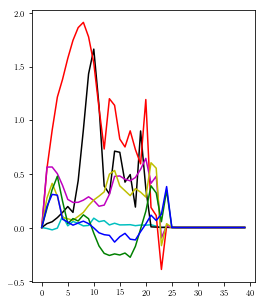

In [45]:
fig,ax=plt.subplots(1,1,figsize=(4,5))
ax.plot(WVMIXNO3[8,:,23],'c-')
ax.plot(WVMIXNO3[9,:,23],'k-')
ax.plot(WVMIXNO3[10,:,23],'r-')
ax.plot(WVMIXNO3[11,:,23],'m-')
ax.plot(WVMIXNO3[12,:,23],'y-')
ax.plot(WVMIXNO3[13,:,23],'g-')
ax.plot(WVMIXNO3[14,:,23],'b-')

In [46]:
np.min(rho090),np.max(rho090)

(16.77363, 22.772007)

In [47]:
np.mean(IPP90),np.mean(IPP90_1)

(0.00021682282, 0.00021463682)

In [48]:
np.max(VMIXNO390),np.max(VMIXNO390_1)

(0.05444895, 0.012724111)

/home/eolson/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


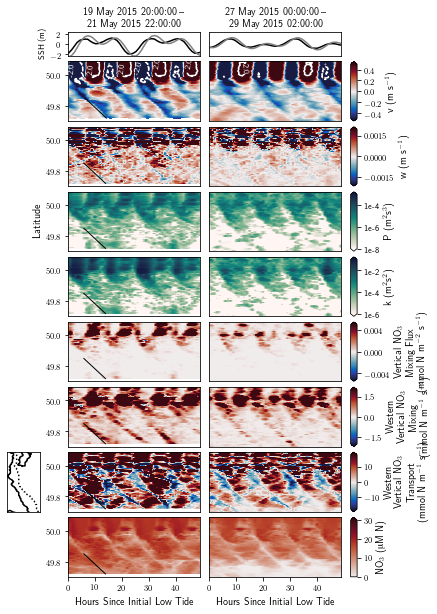

In [49]:
fig=plt.figure(figsize=(6,8.5))
gs0=gridspec.GridSpec(9,3,hspace=.1,wspace=.1,left=.15,right=.82,bottom=.06,top=.95,height_ratios=[.4,1,1,1,1,1,1,1,1],
                      width_ratios=[1,1,.05])

ax00=fig.add_subplot(gs0[0,0])
ax01=fig.add_subplot(gs0[0,1])
ax10=fig.add_subplot(gs0[1,0])
ax11=fig.add_subplot(gs0[1,1])
axcb1=fig.add_subplot(gs0[1,2])
ax20=fig.add_subplot(gs0[2,0])
ax21=fig.add_subplot(gs0[2,1])
axcb2=fig.add_subplot(gs0[2,2])
ax30=fig.add_subplot(gs0[3,0])
ax31=fig.add_subplot(gs0[3,1])
axcb3=fig.add_subplot(gs0[3,2])
ax40=fig.add_subplot(gs0[4,0])
ax41=fig.add_subplot(gs0[4,1])
axcb4=fig.add_subplot(gs0[4,2])
ax50=fig.add_subplot(gs0[5,0])
ax51=fig.add_subplot(gs0[5,1])
axcb5=fig.add_subplot(gs0[5,2])
ax60=fig.add_subplot(gs0[6,0])
ax61=fig.add_subplot(gs0[6,1])
axcb6=fig.add_subplot(gs0[6,2])
ax70=fig.add_subplot(gs0[7,0])
ax71=fig.add_subplot(gs0[7,1])
axcb7=fig.add_subplot(gs0[7,2])
ax80=fig.add_subplot(gs0[8,0])
ax81=fig.add_subplot(gs0[8,1])
axcb8=fig.add_subplot(gs0[8,2])
t0start=dt.datetime(1900,1,1)+dt.timedelta(seconds=tcs[0])-dt.timedelta(minutes=30)
t0end=dt.datetime(1900,1,1)+dt.timedelta(seconds=tcs[-1])+dt.timedelta(minutes=30)
t1start=dt.datetime(1900,1,1)+dt.timedelta(seconds=tcs_1[0])-dt.timedelta(minutes=30)
t1end=dt.datetime(1900,1,1)+dt.timedelta(seconds=tcs_1[-1])+dt.timedelta(minutes=30)

#ax00.plot(st[ilo[tt0]:ilo[tt0]+50])
ax00.plot(st1[tt0:tt0+50],'k-')
ax00.plot(st2[tt0:tt0+50],'-',color='grey')
ax00.set_ylabel('SSH (m)')
tfmt='%d %b %Y %H:%M:%S'
ax00.set_title('{} --\n {}'.format((t0start).strftime(tfmt),(t0end).strftime(tfmt)),fontsize=10)
ax00.set_ylim(-2.3,2.3)
#ax01.plot(st[ilo[7tt1ilo[tt1]+50])
ax01.plot(st1[tt1:tt1+50],'k-')
ax01.plot(st2[tt1:tt1+50],'-',color='grey')
ax01.set_ylabel('SSH (m)',fontsize=10)
tfmt='%d %b %Y %H:%M:%S'
ax01.set_title('{} --\n {}'.format((t1start).strftime(tfmt),(t1end).strftime(tfmt)),fontsize=10)
ax01.set_ylim(-2.3,2.3)
ax00.get_xaxis().set_visible(False)
ax10.get_xaxis().set_visible(False)
ax20.get_xaxis().set_visible(False)
ax30.get_xaxis().set_visible(False)
ax40.get_xaxis().set_visible(False)
ax50.get_xaxis().set_visible(False)
ax60.get_xaxis().set_visible(False)
ax70.get_xaxis().set_visible(False)
ax01.get_xaxis().set_visible(False)
ax11.get_xaxis().set_visible(False)
ax21.get_xaxis().set_visible(False)
ax31.get_xaxis().set_visible(False)
ax41.get_xaxis().set_visible(False)
ax51.get_xaxis().set_visible(False)
ax61.get_xaxis().set_visible(False)
ax71.get_xaxis().set_visible(False)
ax01.get_yaxis().set_visible(False)
ax11.get_yaxis().set_visible(False)
ax21.get_yaxis().set_visible(False)
ax31.get_yaxis().set_visible(False)
ax41.get_yaxis().set_visible(False)
ax51.get_yaxis().set_visible(False)
ax61.get_yaxis().set_visible(False)
ax71.get_yaxis().set_visible(False)
ax81.get_yaxis().set_visible(False)

### v
amp=.5
m=ax10.contourf(np.arange(0,len(tcs)),thlatV90[0,:],np.transpose(hv6),np.linspace(-1*amp,amp,100),vmin=-1*amp,vmax=amp,
                                            cmap=cmb,extend='both')
ml0=ax10.contour(np.arange(0,len(tcs)),thlatV90[0,:],np.transpose(hv6),levels=[-2,2,],colors='w')
ax10.clabel(ml0, fmt='%2.1f', colors='w', fontsize=8)

m=ax11.contourf(np.arange(0,len(tcs)),thlatV90[0,:],np.transpose(hv6_1),np.linspace(-1*amp,amp,100),vmin=-1*amp,vmax=amp,
                                            cmap=cmb,extend='both')
ml1=ax11.contour(np.arange(0,len(tcs)),thlatV90[0,:],np.transpose(hv6_1),levels=[-2,2,],colors='w')
ax11.clabel(ml1, fmt='%2.1f', colors='w', fontsize=8)
ax11.get_yaxis().set_visible(False)
cb=fig.colorbar(m,cax=axcb1,ticks=[-.4,-.2, 0, .2,.4])
cb.set_label('v (m s$^{-1}$)',fontsize=10)

### w
amp=.002
m=ax20.contourf(np.arange(0,len(tcs)),thlatV90[0,:],np.transpose(wvel90+w6),np.linspace(-1*amp,amp,100),
                vmin=-1*amp,vmax=amp,cmap=cmb,extend='both')
#ax20.set_ylabel('Latitude')
m=ax21.contourf(np.arange(0,len(tcs)),thlatV90[0,:],np.transpose(wvel90_1+w6_1),np.linspace(-1*amp,amp,100),
                vmin=-1*amp,vmax=amp,cmap=cmb,extend='both')
cb=fig.colorbar(m,cax=axcb2,ticks=[-.0015, 0, .0015])
cb.set_label('w (m s$^{-1}$)',fontsize=10)

### GLS_P
temp=np.where(GLS_P90==0,1e-9,GLS_P90)
m=ax30.contourf(np.arange(0,len(tcs)),thlatV90[0,:],np.transpose(np.log10(temp)),np.linspace(-8,-3,101),vmin=-8,vmax=-3,
                                            cmap=cmp,extend='both')
ax30.set_ylabel('Latitude',fontsize=10)
temp=np.where(GLS_P90_1==0,1e-9,GLS_P90_1)
m=ax31.contourf(np.arange(0,len(tcs)),thlatV90[0,:],np.transpose(np.log10(temp)),np.linspace(-8,-3,101),vmin=-8,vmax=-3,
                                            cmap=cmp,extend='both')
cb=fig.colorbar(m,cax=axcb3,ticks=[-8,-6, -4])
cb.ax.set_yticklabels(['1e-8', '1e-6', '1e-4'])
cb.set_label('P (m$^2$s$^3$)',fontsize=10)

### GLS_k
temp=np.where(GLS_k90==0,1e-9,GLS_k90)
m=ax40.contourf(np.arange(0,len(tcs)),thlatV90[0,:],np.transpose(np.log10(temp)),np.linspace(-6,-1,101),vmin=-6,vmax=-1,
                                            cmap=cmp,extend='both')
#ax40.set_ylabel('Latitude')
temp=np.where(GLS_k90_1==0,1e-9,GLS_k90_1)
m=ax41.contourf(np.arange(0,len(tcs)),thlatV90[0,:],np.transpose(np.log10(temp)),np.linspace(-6,-1,101),vmin=-6,vmax=-1,
                                            cmap=cmp,extend='both')
cb=fig.colorbar(m,cax=axcb4,ticks=[-6,-4, -2])
cb.ax.set_yticklabels(['1e-6', '1e-4', '1e-2'])
cb.set_label('k (m$^2$s$^2$)',fontsize=10)

### vmix N
amp=.005
m=ax50.contourf(np.arange(0,len(tcs)),thlatV90[0,:],np.transpose(VMIXNO390),np.linspace(-1*amp,amp,100),vmin=-1*amp,vmax=amp,
                                            cmap=cmb,extend='both')
#ax50.set_ylabel('Latitude')
m=ax51.contourf(np.arange(0,len(tcs)),thlatV90[0,:],np.transpose(VMIXNO390_1),np.linspace(-1*amp,amp,100),vmin=-1*amp,vmax=amp,
                                            cmap=cmb,extend='both')
cb=fig.colorbar(m,cax=axcb5,ticks=[-.004,0, .004])
cb.set_label('Vertical NO$_3$\nMixing Flux\n (mmol N m$^{-2}$ s$^{-1}$)',fontsize=10)

### vmix N West
amp=2
m=ax60.contourf(np.arange(0,len(tcs)),thlatV90[0,:],np.transpose(WVMIXNO390),np.linspace(-1*amp,amp,100),vmin=-1*amp,vmax=amp,
                                            cmap=cmb,extend='both')
m=ax61.contourf(np.arange(0,len(tcs)),thlatV90[0,:],np.transpose(WVMIXNO390_1),np.linspace(-1*amp,amp,100),vmin=-1*amp,vmax=amp,
                                            cmap=cmb,extend='both')
cb=fig.colorbar(m,cax=axcb6,ticks=[-1.5,0, 1.5])
cb.set_label('Western\nVertical NO$_3$\nMixing\n(mmol N m$^{-1}$ s$^{-1}$)',fontsize=10)

### WT N West
amp=18
m=ax70.contourf(np.arange(0,len(tcs)),thlatV90[0,:],np.transpose(WTNO390),np.linspace(-1*amp,amp,100),vmin=-1*amp,vmax=amp,
                                            cmap=cmb,extend='both')
m=ax71.contourf(np.arange(0,len(tcs)),thlatV90[0,:],np.transpose(WTNO390_1),np.linspace(-1*amp,amp,100),vmin=-1*amp,vmax=amp,
                                            cmap=cmb,extend='both')
cb=fig.colorbar(m,cax=axcb7,ticks=[-10,0, 10])
cb.set_label('Western\nVertical NO$_3$\nTransport\n(mmol N m$^{-1}$ s$^{-1}$)',fontsize=10)

### N
amp=30
m=ax80.contourf(np.arange(0,len(tcs)),thlatV90[0,:],np.transpose(NO390),np.linspace(0,amp,100),vmin=0,vmax=amp,
                                            cmap=cma,extend='max')
m=ax81.contourf(np.arange(0,len(tcs)),thlatV90[0,:],np.transpose(NO390_1),np.linspace(0,amp,100),vmin=0,vmax=amp,
                                            cmap=cma,extend='max')
cb=fig.colorbar(m,cax=axcb8,ticks=[0,10, 20,30])
cb.set_label('NO$_3$ ($\muup$M N)',fontsize=10)

for axi in (ax00,ax01,ax10,ax11):
    axi.set_xlim(-.5,49)
    
ax80.set_xlabel('Hours Since Initial Low Tide',fontsize=10)
ax81.set_xlabel('Hours Since Initial Low Tide',fontsize=10)

bb=ax70.get_position()
axX=fig.add_axes([bb.x0-.14,bb.y0,bb.width/4,bb.height])
#axX.plot(swid,np.arange(0,len(thlatV90[0,:])))
#axX.set_ylim(0,len(thlatV90[0,:]))
axX.contour(tmaskDIAN[0,:,5:30],levels=[0,],colors='k')
axX.plot(iso90_DIAN[:,1]-5,iso90_DIAN[:,0],'k:')
axX.set_ylim((iso90_DIAN[0,0],iso90_DIAN[-1,0]))
axX.get_yaxis().set_visible(False)
axX.get_xaxis().set_visible(False)

for iax in (ax10,ax20,ax30,ax40,ax50,ax60,ax70,ax80):
    iax.plot((6,14),(49.85,49.72),'k-',lw=1)
    
#fig.savefig('/data/eolson/results/MEOPAR/biomodelevalpaper/figsNNut/hvm6.png',dpi=300)
#fig.savefig('/data/eolson/results/MEOPAR/biomodelevalpaper/figsNNut/hvm6.eps',dpi=400)

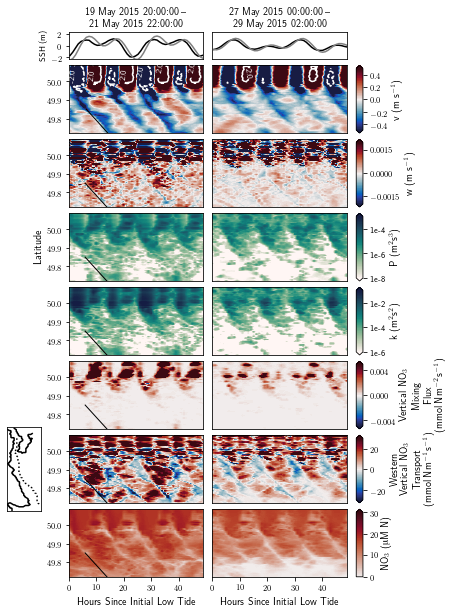

In [55]:
fig=plt.figure(figsize=(6.1,8.5))
gs0=gridspec.GridSpec(8,3,hspace=.1,wspace=.1,left=.15,right=.82,bottom=.06,top=.95,height_ratios=[.4,1,1,1,1,1,1,1],
                      width_ratios=[1,1,.05])

ax00=fig.add_subplot(gs0[0,0])
ax01=fig.add_subplot(gs0[0,1])
ax10=fig.add_subplot(gs0[1,0])
ax11=fig.add_subplot(gs0[1,1])
axcb1=fig.add_subplot(gs0[1,2])
ax20=fig.add_subplot(gs0[2,0])
ax21=fig.add_subplot(gs0[2,1])
axcb2=fig.add_subplot(gs0[2,2])
ax30=fig.add_subplot(gs0[3,0])
ax31=fig.add_subplot(gs0[3,1])
axcb3=fig.add_subplot(gs0[3,2])
ax40=fig.add_subplot(gs0[4,0])
ax41=fig.add_subplot(gs0[4,1])
axcb4=fig.add_subplot(gs0[4,2])
ax50=fig.add_subplot(gs0[5,0])
ax51=fig.add_subplot(gs0[5,1])
axcb5=fig.add_subplot(gs0[5,2])
ax60=fig.add_subplot(gs0[6,0])
ax61=fig.add_subplot(gs0[6,1])
axcb6=fig.add_subplot(gs0[6,2])
ax70=fig.add_subplot(gs0[7,0])
ax71=fig.add_subplot(gs0[7,1])
axcb7=fig.add_subplot(gs0[7,2])
t0start=dt.datetime(1900,1,1)+dt.timedelta(seconds=tcs[0])-dt.timedelta(minutes=30)
t0end=dt.datetime(1900,1,1)+dt.timedelta(seconds=tcs[-1])+dt.timedelta(minutes=30)
t1start=dt.datetime(1900,1,1)+dt.timedelta(seconds=tcs_1[0])-dt.timedelta(minutes=30)
t1end=dt.datetime(1900,1,1)+dt.timedelta(seconds=tcs_1[-1])+dt.timedelta(minutes=30)

ax00.plot(st1[tt0:tt0+50],'k-')
ax00.plot(st2[tt0:tt0+50],'-',color='grey')
ax00.set_ylabel('SSH (m)')
tfmt='%d %b %Y %H:%M:%S'
ax00.set_title('{} --\n {}'.format((t0start).strftime(tfmt),(t0end).strftime(tfmt)),fontsize=10)
ax00.set_ylim(-2.3,2.3)
ax01.plot(st1[tt1:tt1+50],'k-')
ax01.plot(st2[tt1:tt1+50],'-',color='grey')
ax01.set_ylabel('SSH (m)',fontsize=10)
tfmt='%d %b %Y %H:%M:%S'
ax01.set_title('{} --\n {}'.format((t1start).strftime(tfmt),(t1end).strftime(tfmt)),fontsize=10)
ax01.set_ylim(-2.3,2.3)
ax00.get_xaxis().set_visible(False)
ax10.get_xaxis().set_visible(False)
ax20.get_xaxis().set_visible(False)
ax30.get_xaxis().set_visible(False)
ax40.get_xaxis().set_visible(False)
ax50.get_xaxis().set_visible(False)
ax60.get_xaxis().set_visible(False)
ax01.get_xaxis().set_visible(False)
ax11.get_xaxis().set_visible(False)
ax21.get_xaxis().set_visible(False)
ax31.get_xaxis().set_visible(False)
ax41.get_xaxis().set_visible(False)
ax51.get_xaxis().set_visible(False)
ax61.get_xaxis().set_visible(False)
ax01.get_yaxis().set_visible(False)
ax11.get_yaxis().set_visible(False)
ax21.get_yaxis().set_visible(False)
ax31.get_yaxis().set_visible(False)
ax41.get_yaxis().set_visible(False)
ax51.get_yaxis().set_visible(False)
ax61.get_yaxis().set_visible(False)
ax71.get_yaxis().set_visible(False)
for iax in (ax10,ax11,ax20,ax21,ax30,ax31,ax40,ax41,ax50,ax51,ax60,ax61,ax70,ax71):
    iax.set_ylim(thlatV90[0,0],thlatV90[0,-1])

### v
amp=.5
m=ax10.contourf(np.arange(0,len(tcs)),thlatV90[0,:],np.transpose(hv6),np.linspace(-1*amp,amp,100),vmin=-1*amp,vmax=amp,
                                            cmap=cmb,extend='both')
ml0=ax10.contour(np.arange(0,len(tcs)),thlatV90[0,:],np.transpose(hv6),levels=[-2,2,],colors='w')
ax10.clabel(ml0, fmt='%2.1f', colors='w', fontsize=8)

m=ax11.contourf(np.arange(0,len(tcs)),thlatV90[0,:],np.transpose(hv6_1),np.linspace(-1*amp,amp,100),vmin=-1*amp,vmax=amp,
                                            cmap=cmb,extend='both')
ml1=ax11.contour(np.arange(0,len(tcs)),thlatV90[0,:],np.transpose(hv6_1),levels=[-2,2,],colors='w')
ax11.clabel(ml1, fmt='%2.1f', colors='w', fontsize=8)
ax11.get_yaxis().set_visible(False)
cb=fig.colorbar(m,cax=axcb1,ticks=[-.4,-.2, 0, .2,.4])
cb.set_label('v (m s$^{-1}$)',fontsize=10)

### w
amp=.002
m=ax20.contourf(np.arange(0,len(tcs)),thlatV90[0,:],np.transpose(wvel90+w6),np.linspace(-1*amp,amp,100),
                vmin=-1*amp,vmax=amp,cmap=cmb,extend='both')
m=ax21.contourf(np.arange(0,len(tcs)),thlatV90[0,:],np.transpose(wvel90_1+w6_1),np.linspace(-1*amp,amp,100),
                vmin=-1*amp,vmax=amp,cmap=cmb,extend='both')
cb=fig.colorbar(m,cax=axcb2,ticks=[-.0015, 0, .0015])
cb.set_label('w (m s$^{-1}$)',fontsize=10)

### GLS_P
temp=np.where(GLS_P90==0,1e-9,GLS_P90)
m=ax30.contourf(np.arange(0,len(tcs)),thlatV90[0,:],np.transpose(np.log10(temp)),np.linspace(-8,-3,101),vmin=-8,vmax=-3,
                                            cmap=cmp,extend='both')
ax30.set_ylabel('Latitude',fontsize=10)
temp=np.where(GLS_P90_1==0,1e-9,GLS_P90_1)
m=ax31.contourf(np.arange(0,len(tcs)),thlatV90[0,:],np.transpose(np.log10(temp)),np.linspace(-8,-3,101),vmin=-8,vmax=-3,
                                            cmap=cmp,extend='both')
cb=fig.colorbar(m,cax=axcb3,ticks=[-8,-6, -4])
cb.ax.set_yticklabels(['1e-8', '1e-6', '1e-4'])
cb.set_label('P (m$^2$s$^3$)',fontsize=10)

### GLS_k
temp=np.where(GLS_k90==0,1e-9,GLS_k90)
m=ax40.contourf(np.arange(0,len(tcs)),thlatV90[0,:],np.transpose(np.log10(temp)),np.linspace(-6,-1,101),vmin=-6,vmax=-1,
                                            cmap=cmp,extend='both')
#ax40.set_ylabel('Latitude')
temp=np.where(GLS_k90_1==0,1e-9,GLS_k90_1)
m=ax41.contourf(np.arange(0,len(tcs)),thlatV90[0,:],np.transpose(np.log10(temp)),np.linspace(-6,-1,101),vmin=-6,vmax=-1,
                                            cmap=cmp,extend='both')
cb=fig.colorbar(m,cax=axcb4,ticks=[-6,-4, -2])
cb.ax.set_yticklabels(['1e-6', '1e-4', '1e-2'])
cb.set_label('k (m$^2$s$^2$)',fontsize=10)

### vmix N
amp=.005
m=ax50.contourf(np.arange(0,len(tcs)),thlatV90[0,:],np.transpose(VMIXNO390),np.linspace(-1*amp,amp,100),vmin=-1*amp,vmax=amp,
                                            cmap=cmb,extend='both')
#ax50.set_ylabel('Latitude')
m=ax51.contourf(np.arange(0,len(tcs)),thlatV90[0,:],np.transpose(VMIXNO390_1),np.linspace(-1*amp,amp,100),vmin=-1*amp,vmax=amp,
                                            cmap=cmb,extend='both')
cb=fig.colorbar(m,cax=axcb5,ticks=[-.004,0, .004])
cb.set_label('Vertical NO$_3$\nMixing\nFlux\n (mmol$\,$N$\,$m$^{-2}$s$^{-1}$)',fontsize=10)

### WT N West
amp=30
m=ax60.contourf(np.arange(0,len(tcs)),thlatV90[0,:],np.transpose(WTNO390),np.linspace(-1*amp,amp,100),vmin=-1*amp,vmax=amp,
                                            cmap=cmb,extend='both')
m=ax61.contourf(np.arange(0,len(tcs)),thlatV90[0,:],np.transpose(WTNO390_1),np.linspace(-1*amp,amp,100),vmin=-1*amp,vmax=amp,
                                            cmap=cmb,extend='both')
cb=fig.colorbar(m,cax=axcb6,ticks=[-20,0, 20])
cb.set_label('Western\nVertical NO$_3$\nTransport\n(mmol$\,$N$\,$m$^{-1}$s$^{-1}$)',fontsize=10)

### N
amp=30
m=ax70.contourf(np.arange(0,len(tcs)),thlatV90[0,:],np.transpose(NO390),np.linspace(0,amp,100),vmin=0,vmax=amp,
                                            cmap=cma,extend='max')
m=ax71.contourf(np.arange(0,len(tcs)),thlatV90[0,:],np.transpose(NO390_1),np.linspace(0,amp,100),vmin=0,vmax=amp,
                                            cmap=cma,extend='max')
cb=fig.colorbar(m,cax=axcb7,ticks=[0,10, 20,30])
cb.set_label('NO$_3$ ($\muup$M N)',fontsize=10)

for axi in (ax00,ax01,ax10,ax11):
    axi.set_xlim(-.5,49)
    
ax70.set_xlabel('Hours Since Initial Low Tide',fontsize=10)
ax71.set_xlabel('Hours Since Initial Low Tide',fontsize=10)

rat=(jg1-jg0-1)/(iso90_DIAN[-1,0]-iso90_DIAN[0,0])
bb=ax60.get_position()
axX=fig.add_axes([bb.x0-.14,bb.y0-.5*bb.height*(rat-1),bb.width/4,bb.height*rat])
axX.contour(tmaskDIAN[0,:,5:30],levels=[0.5,],colors='k')
axX.plot(iso90_DIAN[:,1]-5,iso90_DIAN[:,0],'k:')
axX.set_ylim((0,jg1-jg0))
axX.get_yaxis().set_visible(False)
axX.get_xaxis().set_visible(False)

for iax in (ax10,ax20,ax30,ax40,ax50,ax60,ax70):
    iax.plot((6,14),(49.85,49.72),'k-',lw=1)

fig.savefig('/data/eolson/results/MEOPAR/biomodelevalpaper/figsNNut/hvm6.png',dpi=300)
fig.savefig('/data/eolson/results/MEOPAR/biomodelevalpaper/figsNNut/hvm6.eps',dpi=400)

In [56]:
np.max(WVMIXNO390),np.min(WVMIXNO390)

(62.128620336656056, -6.35641521818828)

In [57]:
np.arange(0,len(tcs)).shape,np.shape(thlatV90[0,:]),np.transpose(hv6_1).shape

((50,), (105,), (105, 50))

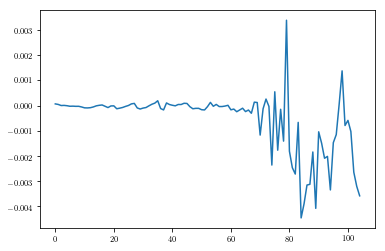

In [58]:
plt.plot(np.mean(wvel90+w6,0))

In [59]:
np.mean(IPP90),np.mean(IPP90_1)

(0.00021682282, 0.00021463682)

In [60]:
np.max(VMIXNO390),np.max(VMIXNO390_1)

(0.05444895, 0.012724111)

49.99073028564453

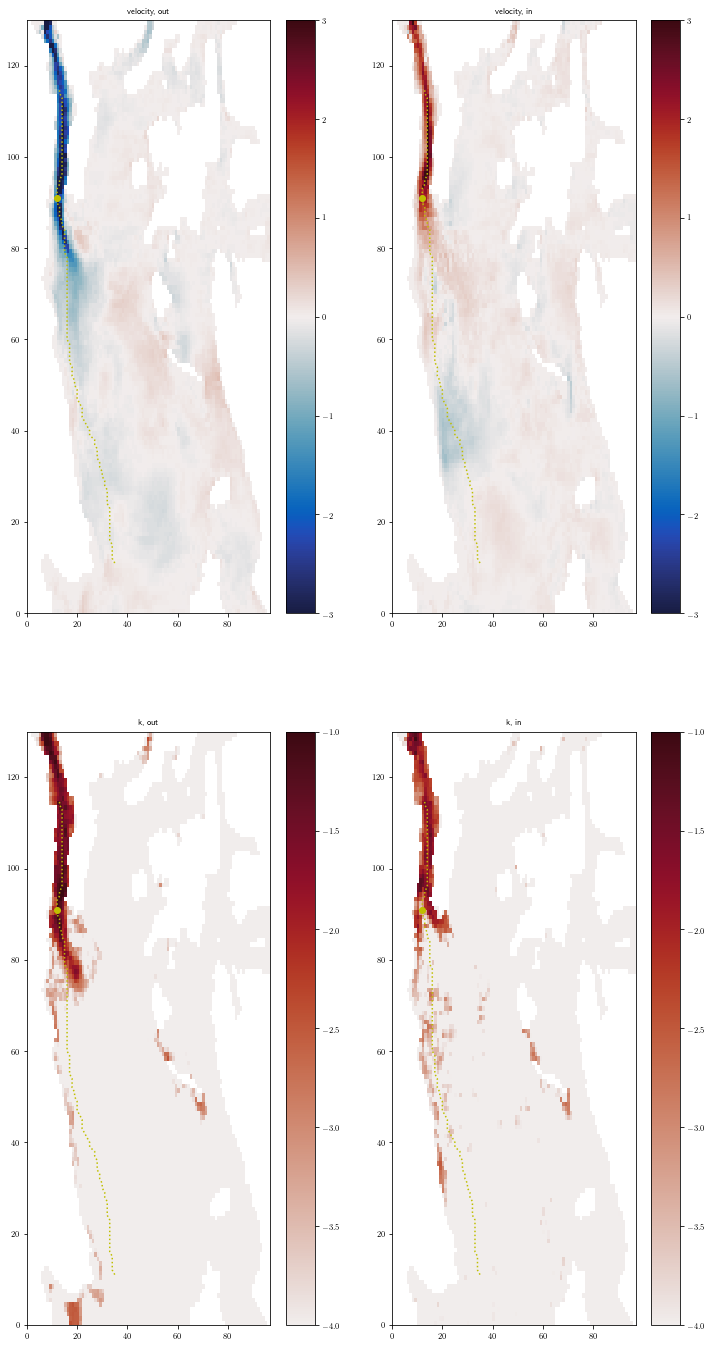

In [61]:
fig,ax=plt.subplots(2,2,figsize=(12,24))
m=ax[0,0].pcolormesh(np.ma.masked_where(tmask[0,jg0:jg1,ig0:ig1]==0,vvel_a6[tt0+3,:,:]),cmap=cmb,vmin=-3,vmax=3)
ax[0,0].set_title('velocity, out')
plt.colorbar(m,ax=ax[0,0])
m=ax[1,0].pcolormesh(np.ma.masked_where(tmask[0,jg0:jg1,ig0:ig1]==0,np.log10(GLS_k_a6[tt0+3,:,:])),cmap=cma,vmin=-4,vmax=-1)
ax[1,0].set_title('k, out')
plt.colorbar(m,ax=ax[1,0])

m=ax[0,1].pcolormesh(np.ma.masked_where(tmask[0,jg0:jg1,ig0:ig1]==0,vvel_a6[tt0+10,:,:]),cmap=cmb,vmin=-3,vmax=3)
ax[0,1].set_title('velocity, in')
plt.colorbar(m,ax=ax[0,1])
m=ax[1,1].pcolormesh(np.ma.masked_where(tmask[0,jg0:jg1,ig0:ig1]==0,np.log10(GLS_k_a6[tt0+10,:,:])),cmap=cma,vmin=-4,vmax=-1)
ax[1,1].set_title('k, in')
plt.colorbar(m,ax=ax[1,1])

for iax in (ax[0,0],ax[0,1],ax[1,0],ax[1,1]):
    iax.plot(iso90_DIAN[:,1],iso90_DIAN[:,0],'y:')
    iax.plot(iso90_DIAN[80,1],iso90_DIAN[80,0],'yo')
thlatV90[0,80]